<a href="https://colab.research.google.com/github/alracey/level4-project/blob/main/1d_piecewise_extended.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, trapezoid

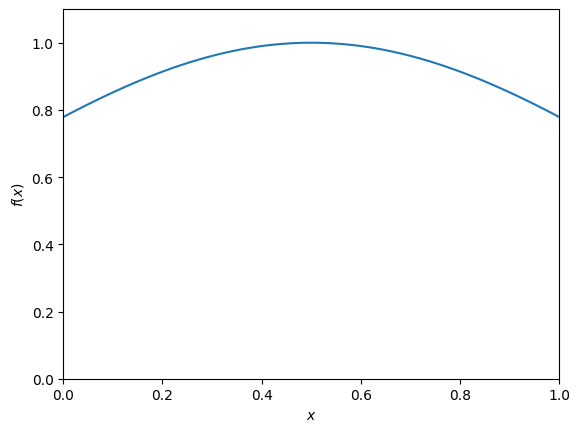

In [2]:
def f(x):
  return np.exp(-(x-0.5)**2)

xs = np.linspace(0, 1, 100)
f_evals = f(xs)
plt.plot(xs, f_evals)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim(0, 1)
plt.ylim(0, 1.1)
plt.show()

In [3]:
K = 5    #NUMBER OF BINS

x_bins = np.linspace(0, 1, K+1)   #edges

y_initial = np.linspace(0, 1, K+1)    #(K+1) heights; (K-1) parameters
params_0 = y_initial[1:-1]


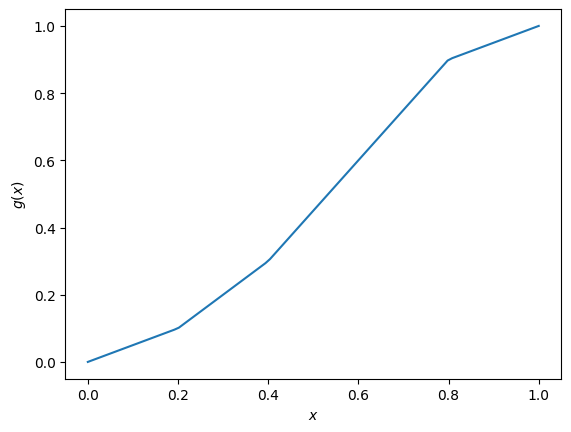

In [4]:
def g_new(x, y_params):
  #using given params, append 0 and 1 to the ends
  ys = np.concatenate(([0.0], y_params, [1.0]))

  #find the correct bin indices i for each x value
  i_values = np.minimum((x*K).astype(int), K-1) # Ensures indices are within the valid range [0, K-1]

  #compute the edges
  x_left = x_bins[i_values]
  x_right = x_bins[i_values + 1]
  y_left = ys[i_values]
  y_right = ys[i_values + 1]

  #compute the linear mappings for all x

  return y_left + ((y_right - y_left) / (x_right - x_left)) * (x - x_left)

test = g_new(xs, np.array([0.1, 0.3, 0.6, 0.9]))
plt.plot(xs, test)
plt.xlabel("$x$")
plt.ylabel("$g(x)$")
plt.show()

[0.77880078 1.58873973 1.6191782  1.64885342 1.67770253 1.7056636
 1.73267581 1.75867971 1.78361742 1.80743283]


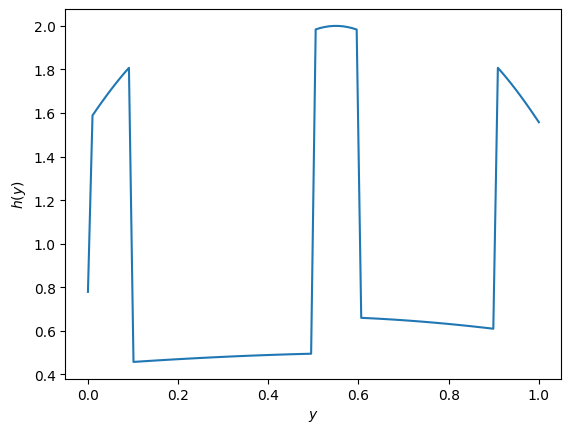

In [12]:
def transformed_f_new(y, y_params):


  #using given params, append 0 and 1 to the ends
  ys = np.concatenate(([0.0], y_params, [1.0]))

  #find the correct bin indices i for each y value
  j_values = np.minimum((np.searchsorted(ys, y) - 1), K - 1)    # Ensures indices are within the valid range [0, K-1]

  #compute the edges
  x_left = x_bins[j_values]
  x_right = x_bins[j_values + 1]
  y_left = ys[j_values]
  y_right = ys[j_values + 1]

  def g_inv_new(y):

    return x_left + ((x_right - x_left) / (y_right - y_left)) * (y - y_left)

  def jacobians(x_left, x_right, y_left, y_right):

    return (x_right - x_left) / (y_right - y_left)

  arg = g_inv_new(y)
  jac = jacobians(x_left, x_right, y_left, y_right)

  return f(arg) * jac


y_test = np.linspace(0, 1, 100)
test_params = np.array([0.1, 0.5, 0.6, 0.9])
transform_test = transformed_f_new(y_test, test_params)
print(transform_test[0:10])
plt.plot(y_test, transform_test)
plt.xlabel("$y$")
plt.ylabel("$h(y)$")
plt.show()

In [6]:
#integration preservation checks

x_int_test, y_int_test = np.linspace(0, 1, 10000), np.linspace(0, 1, 1000000)
h_test_params = np.array([0.1, 0.4, 0.5, 0.8])

f_evals_test = f(x_int_test)
F = trapezoid(f_evals_test, x_int_test)
print("Trapezoid method: F = ", F)
F_q = quad(lambda x: f(x), 0, 1)
print("Quad method: F = ", F_q[0])

H_evals_test = transformed_f_new(y_int_test, h_test_params)
H = trapezoid(H_evals_test, y_int_test)
print("Trapezoid method: H = ", H)
H_q = quad(lambda y: transformed_f_new(y, h_test_params), 0, 1)
print("Quad method: H = ", H_q[0])

Trapezoid method: F =  0.922562011527324
Quad method: F =  0.9225620128255849
Trapezoid method: H =  0.9225611766077242
Quad method: H =  0.9225620128240943


In [7]:
#variance checks

f_var = np.var(f_evals_test)

h_var = np.var(H_evals_test)

print("Variance of f: ", f_var)
print("Variance of h: ", h_var)

Variance of f:  0.004505340906565452
Variance of h:  0.2256619431521238


In [8]:
#optimisation

def objective(y_params, x):
  y = g_new(x, y_params)
  return np.var(transformed_f_new(y, y_params))

obj_test = objective(np.array([ 1.845e-01,  3.921e-01,  6.079e-01,  8.154e-01]), x_int_test)
print(obj_test)

0.0009089143075178527


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0009088665097838503
             x: [ 1.845e-01  3.921e-01  6.079e-01  8.155e-01]
           nit: 52
          nfev: 90
 final_simplex: (array([[ 1.845e-01,  3.921e-01,  6.079e-01,  8.155e-01],
                       [ 1.845e-01,  3.920e-01,  6.079e-01,  8.154e-01],
                       ...,
                       [ 1.845e-01,  3.921e-01,  6.079e-01,  8.154e-01],
                       [ 1.845e-01,  3.921e-01,  6.080e-01,  8.155e-01]]), array([ 9.089e-04,  9.089e-04,  9.089e-04,  9.089e-04,
                        9.089e-04]))
0.7788007830714049 0.8486893016982875 0.8440769891725912


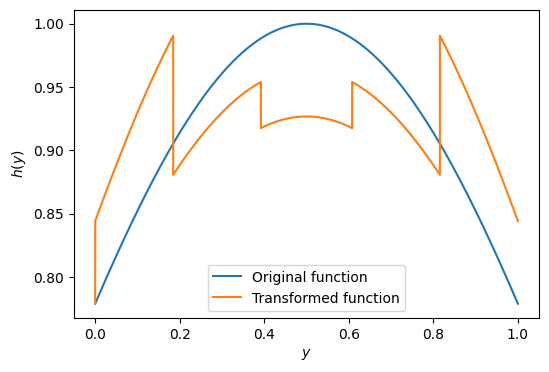

In [14]:
from scipy.optimize import minimize

initial_params = np.array([1.845e-01,  3.921e-01,  6.079e-01,  8.154e-01])
x_values = np.linspace(0, 1, 10000)
y_values = np.linspace(0, 1, 10000)

#constraints

#bounds

result = minimize(
    objective,
    initial_params,
    args=(x_values),
    method='Nelder-Mead'
)

opt_params = result.x
print(result)

#plotting

plt.figure(figsize=(6, 4))
plt.plot(x_values, f(x_values), label="Original function")
opt_h = transformed_f_new(y_values, opt_params)
print(opt_h[0], opt_h[50], opt_h[-1])
plt.plot(y_values, opt_h, label="Transformed function")
plt.xlabel("$y$")
plt.ylabel("$h(y)$")
plt.legend()
plt.show()

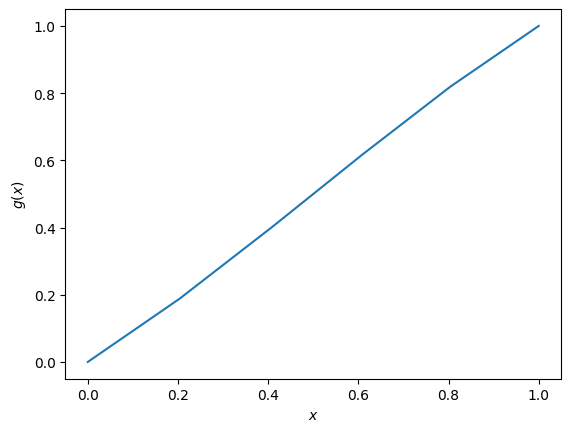

In [17]:
plt.plot(x_values, g_new(x_values, np.array([1.845e-01,  3.921e-01,  6.079e-01,  8.155e-01])))
plt.xlabel("$x$")
plt.ylabel("$g(x)$")
plt.show()

In [10]:
y_bins = np.array([0.0, 0.1, 0.3, 0.6, 0.9, 1.0])
y = np.array([0.05, 0.2, 0.4, 0.8])
print(np.searchsorted(y_bins, y))


[1 2 3 4]
